In [1]:
# %load honest_net.py
import numpy as np
import pandas as pd

import seaborn as sns
# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/honest_net.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


# C&P from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except TypeError:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    d = {}

    def wsg(k, v):
        d[k + "_weakest"] = v[weakest]
        d[k + "_strongest"] = v[strongest]
        d[k + "_gini"] = gini(v)

    rcompute = compute / np.sum(compute)
    wsg("compute", rcompute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / np.sum(activations)
    wsg("activations", ractivations)
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    wsg("reward", rreward)
    efficiency = rreward / ractivations
    wsg("efficiency", efficiency)
    d["activations_compute_gini_delta"] = d["activations_gini"] - d["compute_gini"]
    d["reward_activations_gini_delta"] = d["reward_gini"] - d["activations_gini"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

## Incentive Schemes for Georges  Protocol

In [2]:
d = df[df.protocol == "george"]

### Efficiency of the weakest miner

We pick the weakest miner by compute power and calculate its

efficiency = relative reward / relative activations

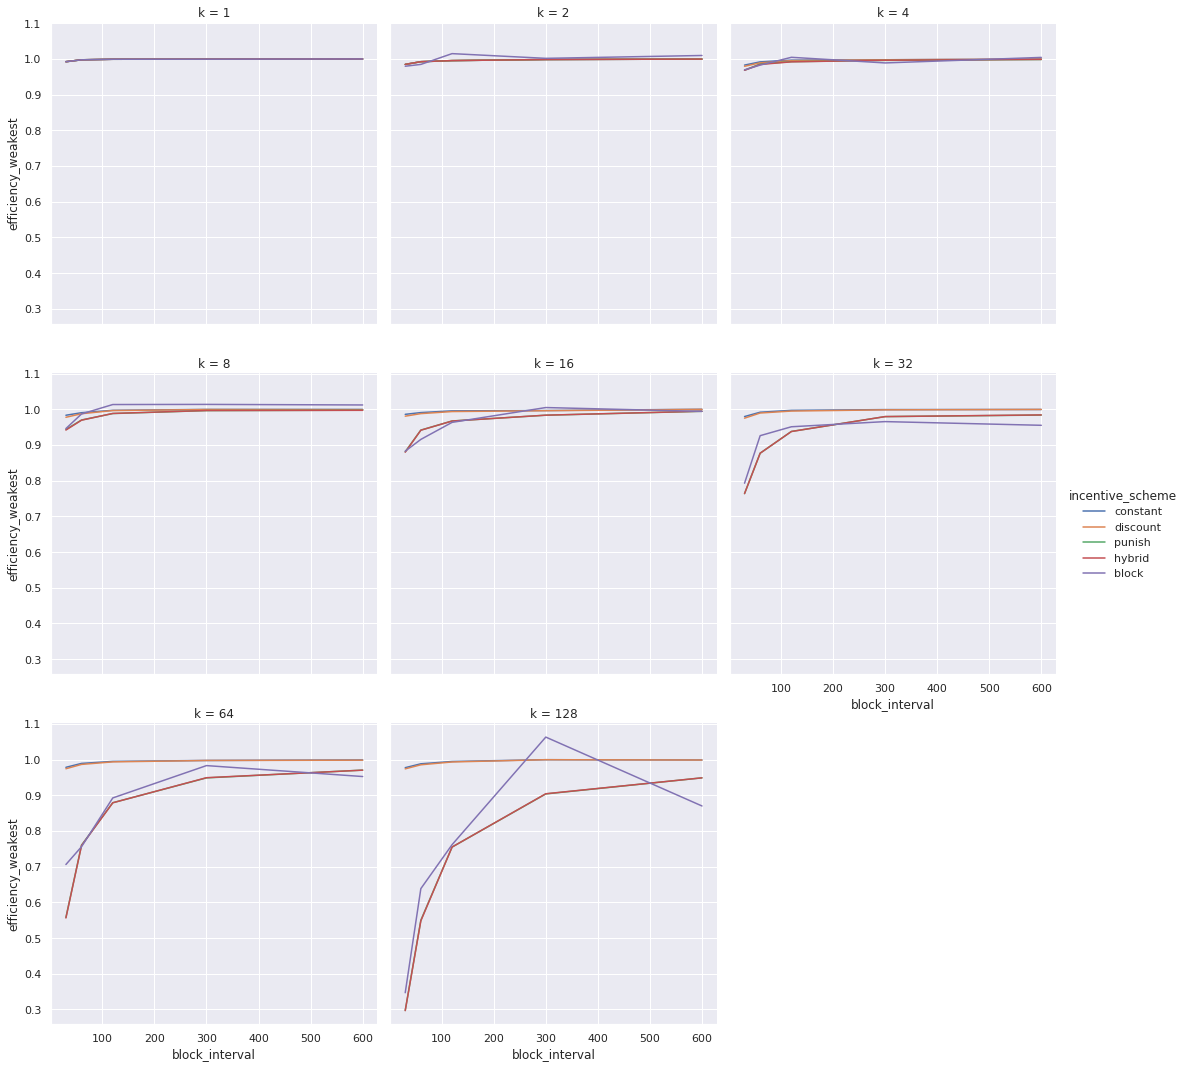

In [3]:
sns.relplot(
    data=d,
    x="block_interval", y="efficiency_weakest", col="k", col_wrap=3,
    hue="incentive_scheme", kind="line",
)

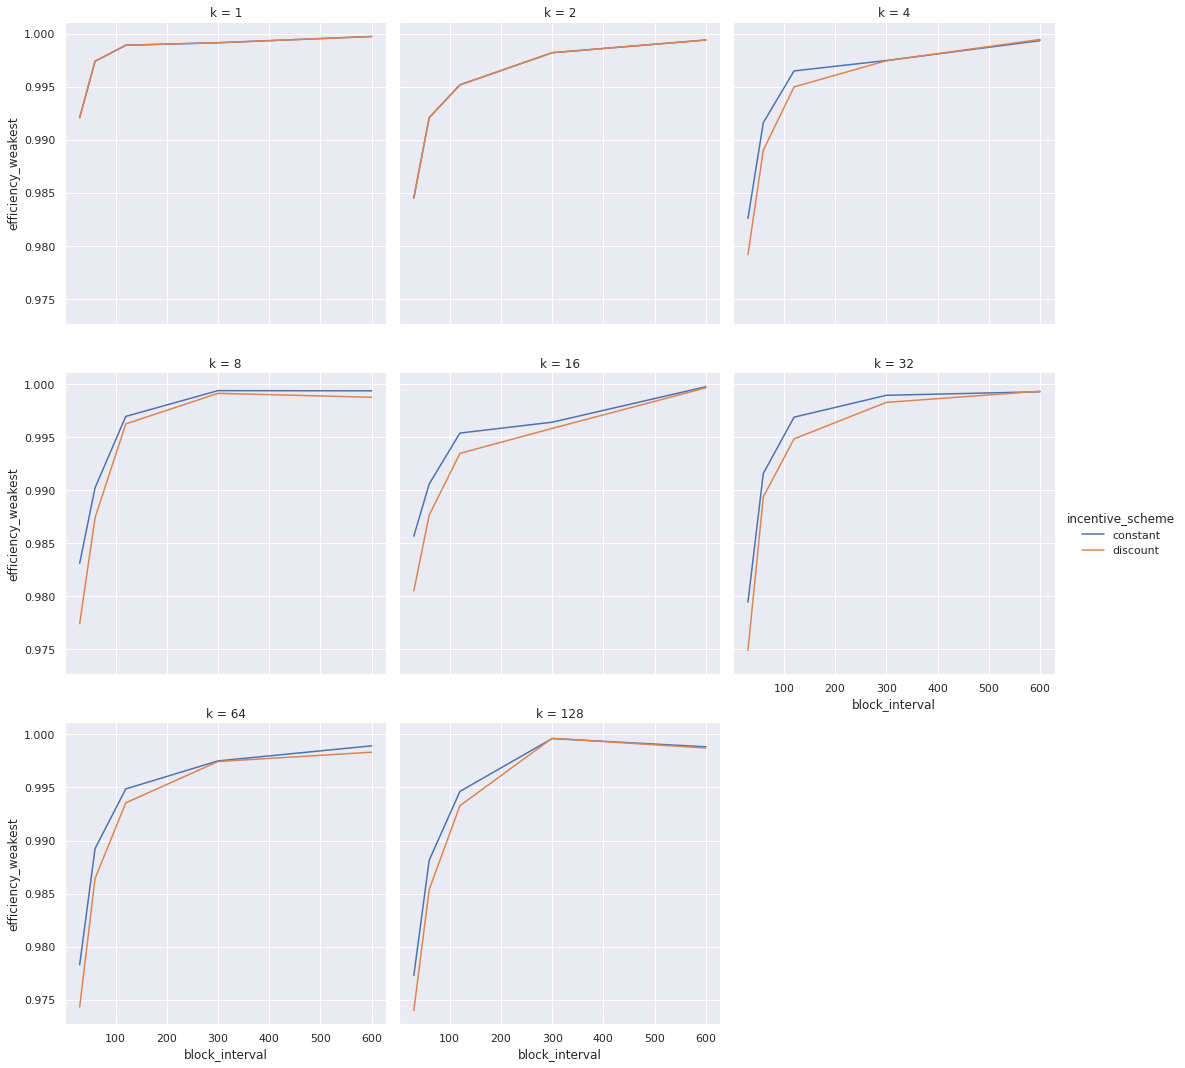

In [4]:
sns.relplot(
    data=d[(d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")],
    x="block_interval", y="efficiency_weakest", col="k", col_wrap=3,
    hue="incentive_scheme", kind="line",
)

In [5]:
eff = d.rename(
    columns={'incentive_scheme': 'Incentive Scheme',
            'block_interval': 'Block Interval'}
).pivot(
    index=["Block Interval", "k"],
    columns=["Incentive Scheme"],
    values="efficiency_weakest",
)
eff.to_latex(buf="../../tex/george-reward-inequality/tab/efficiency-weakest.tex")
eff

Incentive Scheme       block  constant  discount    hybrid    punish
Block Interval k                                                    
30.0           1    0.992089  0.992089  0.992089  0.992089  0.992089
               2    0.979370  0.984524  0.984524  0.984524  0.984524
               4    0.969144  0.982597  0.979192  0.968015  0.968317
               8    0.945803  0.983121  0.977423  0.941657  0.943261
               16   0.882500  0.985670  0.980514  0.879682  0.880920
               32   0.792723  0.979461  0.974919  0.763680  0.763675
               64   0.706071  0.978301  0.974315  0.556296  0.557793
               128  0.346941  0.977279  0.973979  0.296788  0.297215
60.0           1    0.997408  0.997408  0.997408  0.997408  0.997408
               2    0.984510  0.992090  0.992090  0.992090  0.992090
               4    0.982581  0.991625  0.989028  0.984381  0.985651
               8    0.986718  0.990231  0.987405  0.969290  0.969853
               16   0.915465  0.990583  0.987649  0.941182  0.941490
               32   0.925923  0.991585  0.989370  0.876803  0.876778
               64   0.755949  0.989245  0.986418  0.759216  0.760301
               128  0.638507  0.988145  0.985370  0.548299  0.550002
120.0          1    0.998914  0.998914  0.998914  0.998914  0.998914
               2    1.014695  0.995182  0.995182  0.995182  0.995182
               4    1.004402  0.996496  0.994990  0.991689  0.992175
               8    1.013124  0.996954  0.996247  0.988202  0.987836
               16   0.963169  0.995384  0.993471  0.966911  0.967085
               32   0.950865  0.996880  0.994839  0.937554  0.937743
               64   0.892522  0.994865  0.993553  0.878929  0.879094
               128  0.761628  0.994631  0.993289  0.755009  0.754911
300.0          1    0.999150  0.999150  0.999150  0.999150  0.999150
               2    1.001489  0.998209  0.998209  0.998209  0.998209
               4    0.988634  0.997473  0.997453  0.996140  0.995720
               8    1.013500  0.999380  0.999127  0.996325  0.996137
               16   1.004682  0.996407  0.995822  0.983355  0.983204
               32   0.965302  0.998942  0.998272  0.979342  0.979332
               64   0.983097  0.997505  0.997446  0.949199  0.948667
               128  1.062957  0.999608  0.999635  0.904243  0.903759
600.0          1    0.999739  0.999739  0.999739  0.999739  0.999739
               2    1.009494  0.999407  0.999407  0.999407  0.999407
               4    1.004113  0.999346  0.999459  0.998562  0.998153
               8    1.011927  0.999362  0.998755  0.996917  0.997235
               16   0.993903  0.999748  0.999647  0.994388  0.994160
               32   0.954984  0.999276  0.999328  0.984063  0.983589
               64   0.952486  0.998924  0.998324  0.970315  0.970486
               128  0.870018  0.998832  0.998715  0.948818  0.948775

### Reward Gini Fairness

We compare the rewards of all miners using the Gini coefficient. A lower coefficient implies more fairness. All numbers should be compared to the Gini coefficient of the compute powers.

In [6]:
d.compute_gini.unique()

array([0.3])

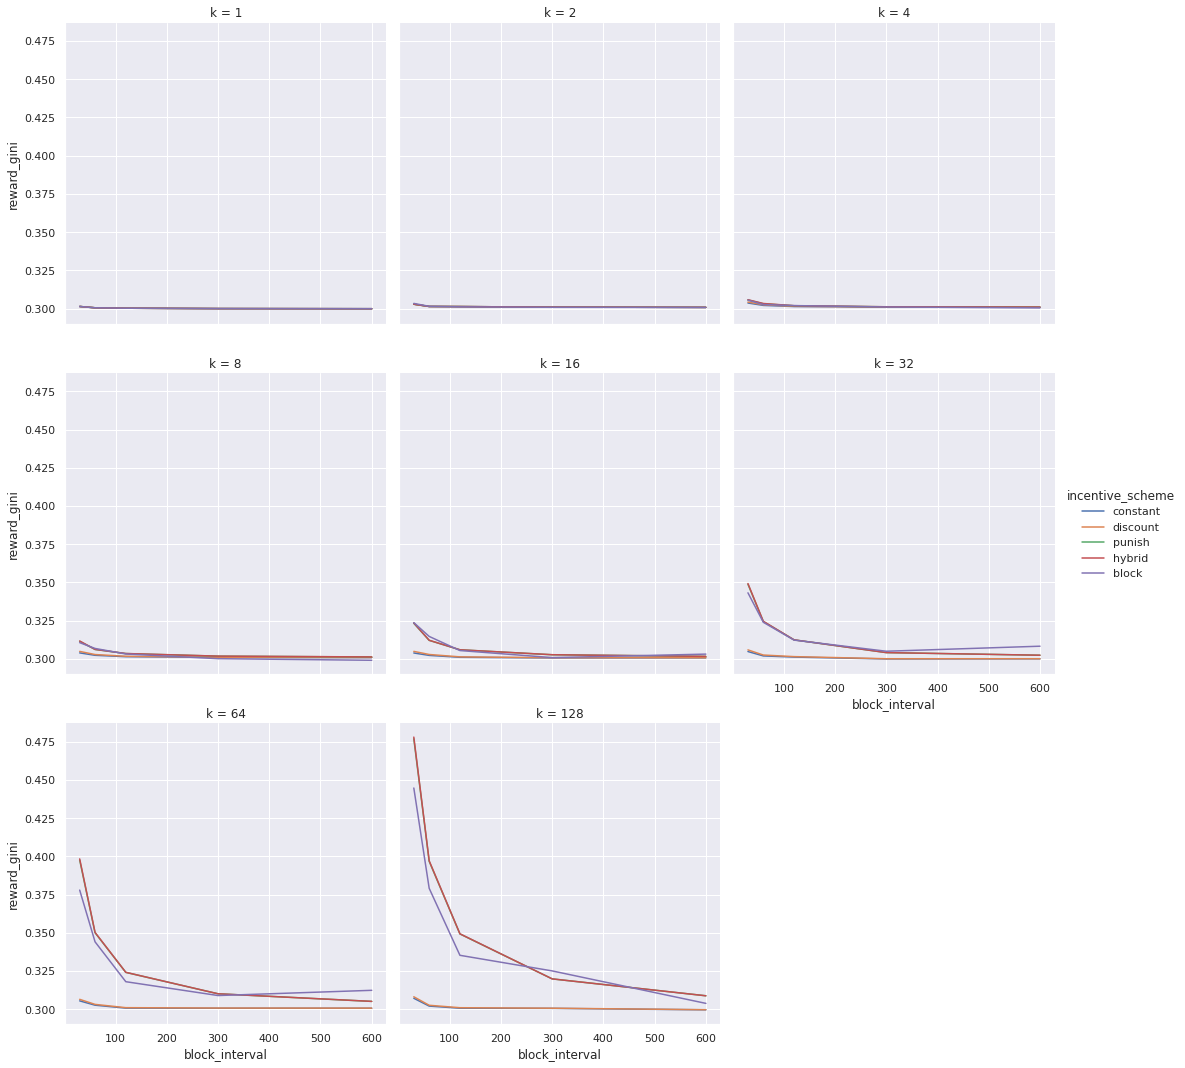

In [7]:
sns.relplot(
    data=d,
    x="block_interval", y="reward_gini", col="k", col_wrap=3,
    hue="incentive_scheme", kind="line",
)

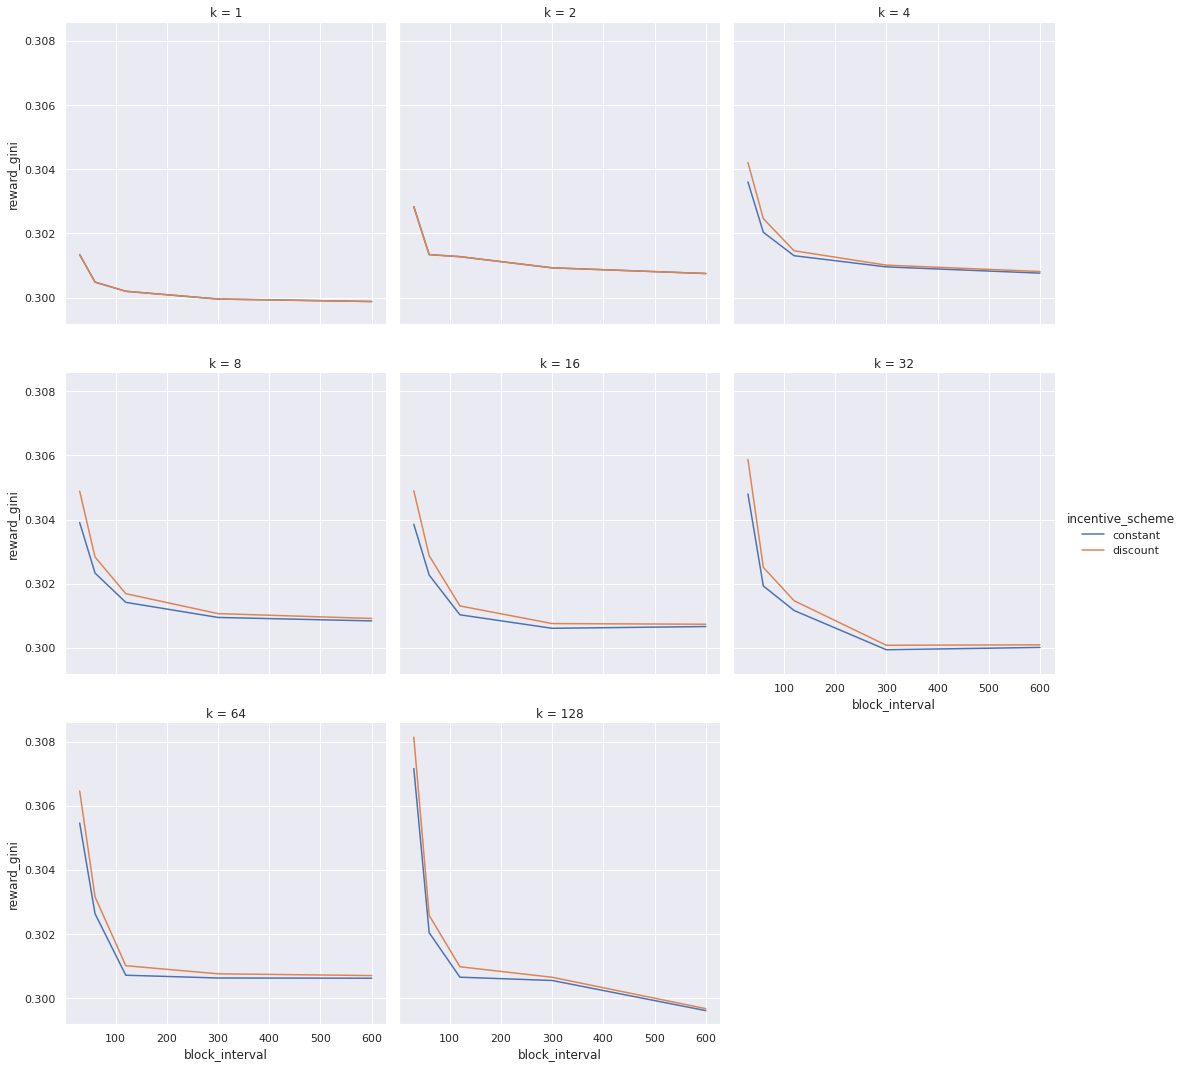

In [8]:
sns.relplot(
    data=d[(d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")],
    x="block_interval", y="reward_gini", col="k", col_wrap=3,
    hue="incentive_scheme", kind="line",
)

In [9]:
gini = d.rename(
    columns={'incentive_scheme': 'Incentive Scheme',
            'block_interval': 'Block Interval'}
).pivot(
    index=["Block Interval", "k"],
    columns=["Incentive Scheme"],
    values="reward_gini",
)
gini.to_latex(buf="../../tex/george-reward-inequality/tab/reward-gini.tex")
gini

Incentive Scheme       block  constant  discount    hybrid    punish
Block Interval k                                                    
30.0           1    0.301341  0.301341  0.301341  0.301341  0.301341
               2    0.303348  0.302833  0.302833  0.302833  0.302833
               4    0.305474  0.303605  0.304212  0.305758  0.305595
               8    0.310609  0.303909  0.304887  0.311687  0.311513
               16   0.323702  0.303854  0.304898  0.323519  0.323269
               32   0.343210  0.304800  0.305874  0.349275  0.348806
               64   0.377924  0.305462  0.306460  0.398329  0.397588
               128  0.444700  0.307160  0.308140  0.478010  0.476899
60.0           1    0.300484  0.300484  0.300484  0.300484  0.300484
               2    0.301437  0.301341  0.301341  0.301341  0.301341
               4    0.302621  0.302038  0.302462  0.303290  0.303116
               8    0.306823  0.302334  0.302835  0.306213  0.306142
               16   0.314684  0.302272  0.302875  0.312181  0.312095
               32   0.323930  0.301933  0.302513  0.324570  0.324422
               64   0.344082  0.302635  0.303163  0.350253  0.350017
               128  0.379089  0.302045  0.302583  0.397107  0.396721
120.0          1    0.300198  0.300198  0.300198  0.300198  0.300198
               2    0.301106  0.301277  0.301277  0.301277  0.301277
               4    0.301921  0.301307  0.301461  0.301842  0.301811
               8    0.303194  0.301422  0.301693  0.303501  0.303474
               16   0.305443  0.301034  0.301311  0.305951  0.305940
               32   0.312274  0.301169  0.301473  0.312458  0.312438
               64   0.318006  0.300720  0.301017  0.324140  0.324098
               128  0.335267  0.300659  0.300984  0.349340  0.349235
300.0          1    0.299957  0.299957  0.299957  0.299957  0.299957
               2    0.300812  0.300929  0.300929  0.300929  0.300929
               4    0.301003  0.300958  0.301013  0.301146  0.301136
               8    0.300130  0.300952  0.301071  0.301801  0.301784
               16   0.300827  0.300614  0.300761  0.302722  0.302694
               32   0.304996  0.299946  0.300086  0.304106  0.304096
               64   0.308948  0.300634  0.300764  0.310106  0.310098
               128  0.325061  0.300556  0.300657  0.319847  0.319845
600.0          1    0.299879  0.299879  0.299879  0.299879  0.299879
               2    0.300703  0.300752  0.300752  0.300752  0.300752
               4    0.300425  0.300764  0.300815  0.300915  0.300897
               8    0.299081  0.300844  0.300920  0.301272  0.301246
               16   0.303110  0.300669  0.300740  0.301634  0.301620
               32   0.308286  0.300017  0.300099  0.302392  0.302376
               64   0.312363  0.300627  0.300710  0.305128  0.305107
               128  0.303825  0.299617  0.299678  0.308789  0.308790